## Importing data and libraries

In [29]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import requests
from tabulate import tabulate
import ast
import re


In [30]:
# Initialize a BigQuery client
client = bigquery.Client(project='container-testing-381309')

# Function to execute BigQuery and return results as a DataFrame
def run_bigquery(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# Read user_info table
user_info_query = """
SELECT *
FROM `container-testing-381309.telegram.user_info`
"""
user_info_df = run_bigquery(user_info_query)

# Read chat_history table
chat_history_query = """
SELECT 
    ch.*,
    COALESCE(ui.bot, FALSE) as is_bot
FROM `container-testing-381309.telegram.chat_history` ch
LEFT JOIN `container-testing-381309.telegram.user_info` ui
ON ch.from_user = ui.id
"""
chat_history_df = run_bigquery(chat_history_query)

# Read chat_info table
chat_info_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_info`
"""

chat_info_df = run_bigquery(chat_info_query)

#before fixing this in ETL logic, chat history was automatically adding a -100 prefix to chat_id
#To have identical chat_id in all tables, we need to remove this prefix from chat_id in chat_history table
# Remove the "-100" prefix from chat_id
chat_history_df['id'] = chat_history_df['id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x))
chat_history_df['id'] = chat_history_df['id'].astype(int)
chat_history_df = chat_history_df.merge(chat_info_df, on='id', how='left')
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])


Human massages and bot massages seperation

In [31]:
#Separate bot and human messages  also for further analysis
bot_messages_df = chat_history_df[chat_history_df['is_bot'] == True]
human_messages_df = chat_history_df[chat_history_df['is_bot'] == False]

Color scheme for fun

In [32]:
def set_custom_color_scheme():
    # Define a custom color palette with muted shades of green and yellow
    custom_palette = ["#a3d977", "#6bbf59", "#d7e87e", "#97c95d", "#d0e0a3", "#88b98b"]
    
    # Apply the color palette to Seaborn
    sns.set_palette(custom_palette)
    
    # Apply the color palette to Matplotlib
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette)
    
    # Set other Matplotlib default styles with black text
    plt.rcParams['axes.labelcolor'] = '#000000'  # Black for axis labels
    plt.rcParams['xtick.color'] = '#000000'      # Black for x-ticks
    plt.rcParams['ytick.color'] = '#000000'      # Black for y-ticks
    plt.rcParams['grid.color'] = '#d7e87e'       # Soft yellow for grid lines
    plt.rcParams['text.color'] = '#000000'       # Black for all text
    plt.rcParams['figure.facecolor'] = '#ffffff' # White background for figure
    plt.rcParams['axes.facecolor'] = '#ffffff'   # White background for axes

# Apply the color scheme to your plots
set_custom_color_scheme()


## Dataset information

% of missing data by field

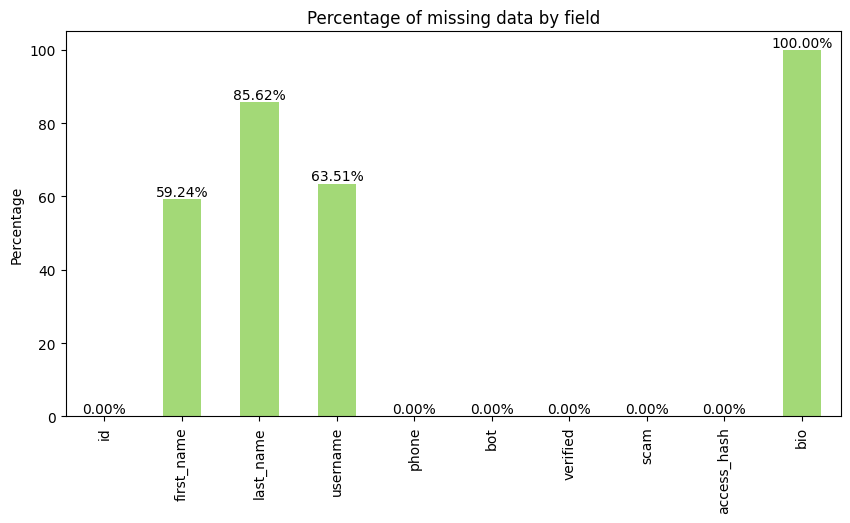

Percentage of bots: 0.30%


In [33]:
missing_data = user_info_df.isnull().sum() / len(user_info_df) * 100
plt.figure(figsize=(10, 5))
ax = missing_data.plot(kind='bar')
plt.title('Percentage of missing data by field')
plt.ylabel('Percentage')

# Add percentage on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()


# 7. Bot Detection and Analysis
bot_percentage = (user_info_df['bot'].sum() / len(user_info_df)) * 100
print(f"Percentage of bots: {bot_percentage:.2f}%")

Statistics for each column in history table

In [34]:
def check_data_quality(df):
    total_rows = len(df)
    quality_check = {}

    quality_check['id'] = (df['id'].notna() & (df['id'] != 'šteilke')).sum()
    quality_check['date'] = (df['date'].notna() & (df['date'] != 'null')).sum()
    quality_check['from_user'] = df['from_user'].notna().sum()
    quality_check['text'] = (df['text'] != '').sum()
    quality_check['sender'] = df['sender'].notna().sum()
    quality_check['chat_id'] = df['chat_id'].notna().sum()
    quality_check['is_reply'] = df['is_reply'].notna().sum()
    quality_check['views'] = (df['views'] > 0).sum()
    quality_check['forwards'] = (df['forwards'] > 0).sum()
    quality_check['replies'] = (df['replies'] > 0).sum()
    quality_check['buttons'] = (df['buttons'] != 'None').sum()
    quality_check['media'] = df['media'].notna().sum()
    quality_check['mentioned'] = df['mentioned'].notna().sum()
    quality_check['post_author'] = (df['post_author'] > 0).sum()
    quality_check['edit_date'] = (df['edit_date'] != 0.0).sum()
    quality_check['via_bot'] = (df['via_bot'] > 0).sum()
    quality_check['reply_to_msg_id'] = df['reply_to_msg_id'].notna().sum()
    quality_check['reactions'] = (df['reactions'] != '').sum()
    quality_check['grouped_id'] = (df['grouped_id'] > 0).sum()
    quality_check['action'] = df['action'].notna().sum()

    quality_df = pd.DataFrame({
        'Field': quality_check.keys(),
        'Actual Data': quality_check.values(),
        'Empty/Null/Default': total_rows - pd.Series(quality_check.values()),
        'Percentage Actual': (pd.Series(quality_check.values()) / total_rows * 100).round(2),
        'Total': total_rows
    })

    return quality_df

# Run the analysis
quality_results = check_data_quality(chat_history_df)

# Display the results
print(tabulate(quality_results, headers='keys', tablefmt='psql'))

+----+-----------------+---------------+----------------------+---------------------+---------+
|    | Field           |   Actual Data |   Empty/Null/Default |   Percentage Actual |   Total |
|----+-----------------+---------------+----------------------+---------------------+---------|
|  0 | id              |         15339 |                    0 |              100    |   15339 |
|  1 | date            |         15339 |                    0 |              100    |   15339 |
|  2 | from_user       |         15333 |                    6 |               99.96 |   15339 |
|  3 | text            |         15019 |                  320 |               97.91 |   15339 |
|  4 | sender          |         15339 |                    0 |              100    |   15339 |
|  5 | chat_id         |         15339 |                    0 |              100    |   15339 |
|  6 | is_reply        |         15339 |                    0 |              100    |   15339 |
|  7 | views           |            20 |

Message activity - average daily

In [35]:
# Calculate the average number of messages per day for bot and human
#human
avg_human_messages = human_messages_df.groupby(human_messages_df['date'].dt.date).size().mean()
print(f"Average number of human messages per day: {avg_human_messages:.2f}")

#bot
avg_bot_messages = bot_messages_df.groupby(bot_messages_df['date'].dt.date).size().mean()
print(f"Average number of bot messages per day: {avg_bot_messages:.2f}")

Average number of human messages per day: 447.67
Average number of bot messages per day: 120.44


Message lenght destribution

count    15339.000000
mean       124.442337
std        252.062254
min          0.000000
25%         19.000000
50%         52.000000
75%        131.000000
max       4107.000000
Name: message_length, dtype: float64


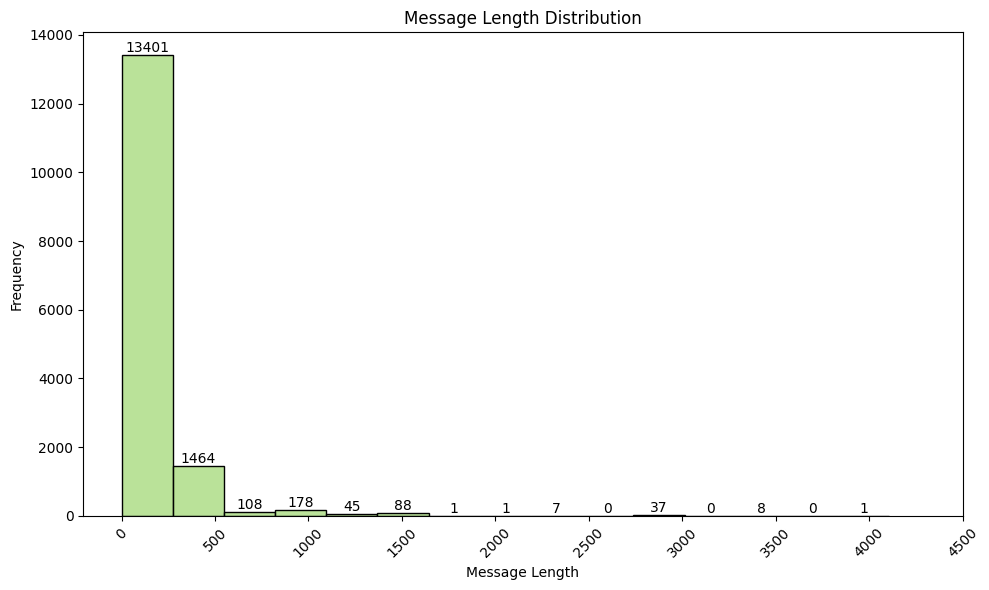

In [36]:
chat_history_df['message_length'] = chat_history_df['text'].astype(str).str.len()

print(chat_history_df['message_length'].describe())

plt.figure(figsize=(10, 6))
ax = sns.histplot(chat_history_df['message_length'], bins=15, kde=False)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')

# Add numbering on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Increase the number of ticks on the x-axis to every 500 units
max_length = chat_history_df['message_length'].max()
plt.xticks(ticks=range(0, max_length + 500, 500), rotation=45)

plt.tight_layout()
plt.show()


Destribution of a bot users

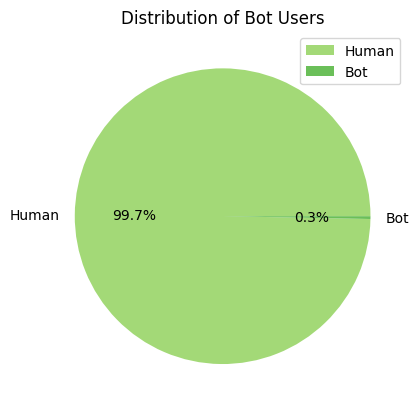

In [37]:
bot_users = user_info_df['bot'].value_counts()
bot_users_df = pd.DataFrame({'is_bot': bot_users.index, 'count': bot_users.values})
bot_users_df['is_bot'] = bot_users_df['is_bot'].map({True: 'Bot', False: 'Human'})
bot_users_df.plot(kind='pie', y='count', labels=bot_users_df['is_bot'], autopct='%1.1f%%')
plt.title('Distribution of Bot Users')
plt.ylabel('')
plt.show()

## Analysis of different statistics

Daily massage acctivity

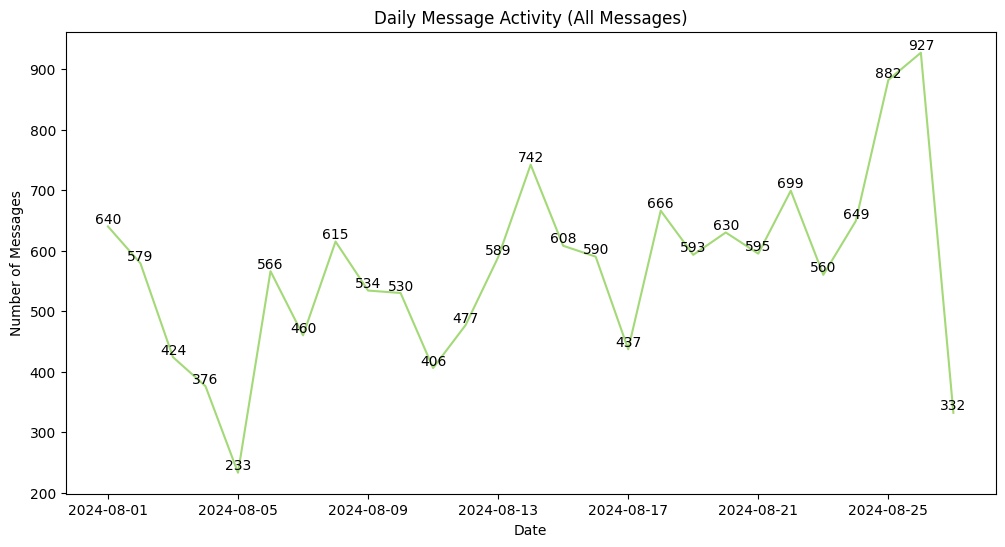

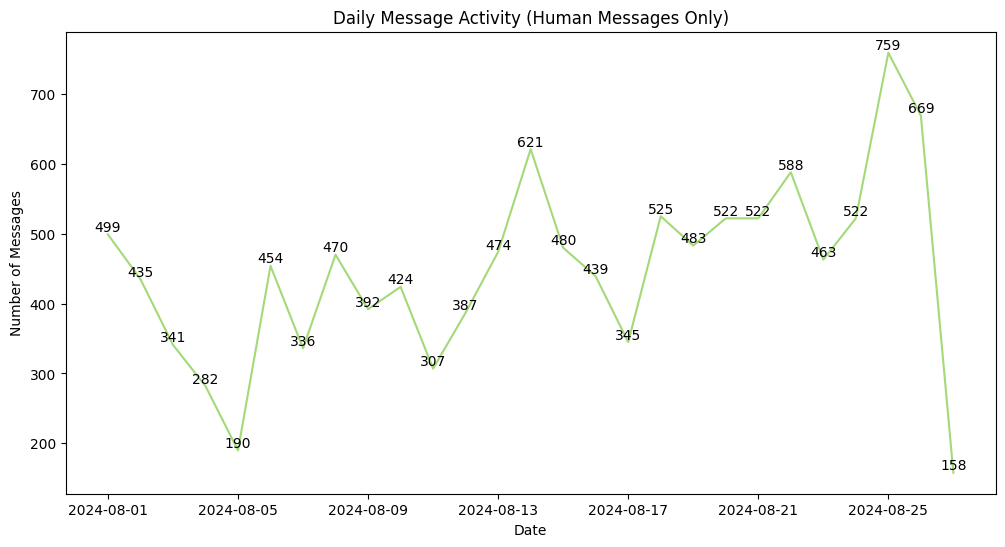

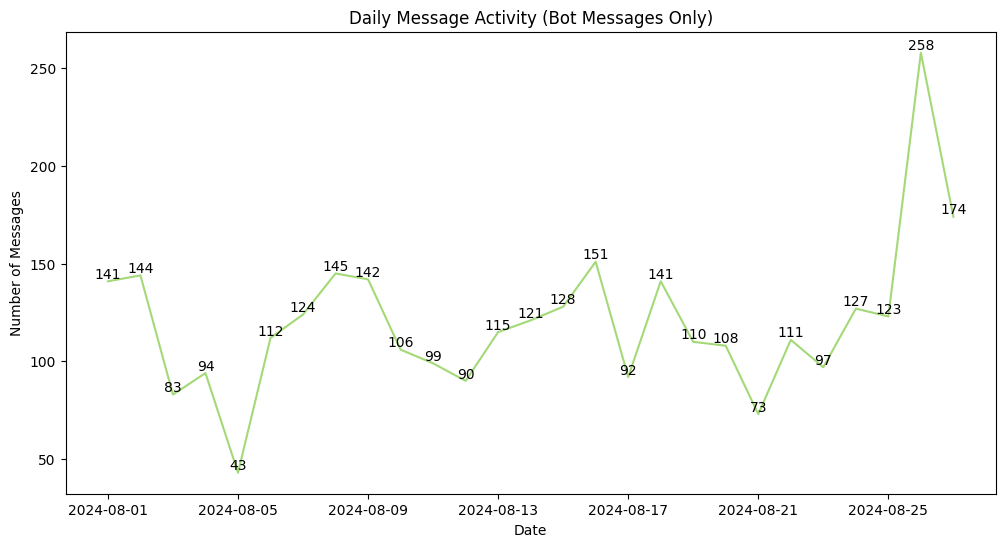

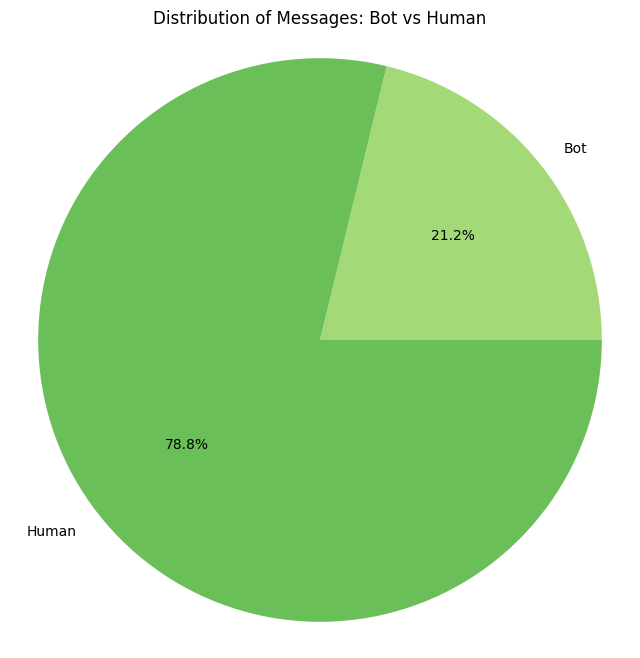

In [38]:

def plot_daily_activity(df, title):
    # Group by date and count the number of messages
    daily_activity = df.groupby(df['date'].dt.date).size()
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    ax = daily_activity.plot()
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    
    # Annotate each point on the graph with its value
    for i, value in enumerate(daily_activity):
        ax.text(daily_activity.index[i], value, str(value), ha='center', va='bottom')

    # Show the plot
    plt.show()


def plot_bot_human_distribution():
    message_counts = chat_history_df['is_bot'].value_counts()
    bot_messages = message_counts.get(True, 0)
    human_messages = message_counts.get(False, 0)

    plt.figure(figsize=(8, 8))
    plt.pie([bot_messages, human_messages], labels=['Bot', 'Human'], autopct='%1.1f%%')
    plt.title('Distribution of Messages: Bot vs Human')
    plt.axis('equal')
    plt.show()


# Plot daily activity for all messages
plot_daily_activity(chat_history_df, 'Daily Message Activity (All Messages)')

# Plot daily activity for human messages only
plot_daily_activity(human_messages_df, 'Daily Message Activity (Human Messages Only)')

# Plot daily activity for bot messages only
plot_daily_activity(bot_messages_df, 'Daily Message Activity (Bot Messages Only)')

# Plot distribution of bot vs human messages
plot_bot_human_distribution()    

Top active users - all chats together

/var/folders/gf/7_bh9lyn3fb01vysrym11jqh0000gn/T/ipykernel_88083/754164155.py:33: UserWarning: Glyph 8295 (\N{RIGHT-TO-LEFT ISOLATE}) missing from current font.
  plt.tight_layout()
/Users/ajda/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8295 (\N{RIGHT-TO-LEFT ISOLATE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


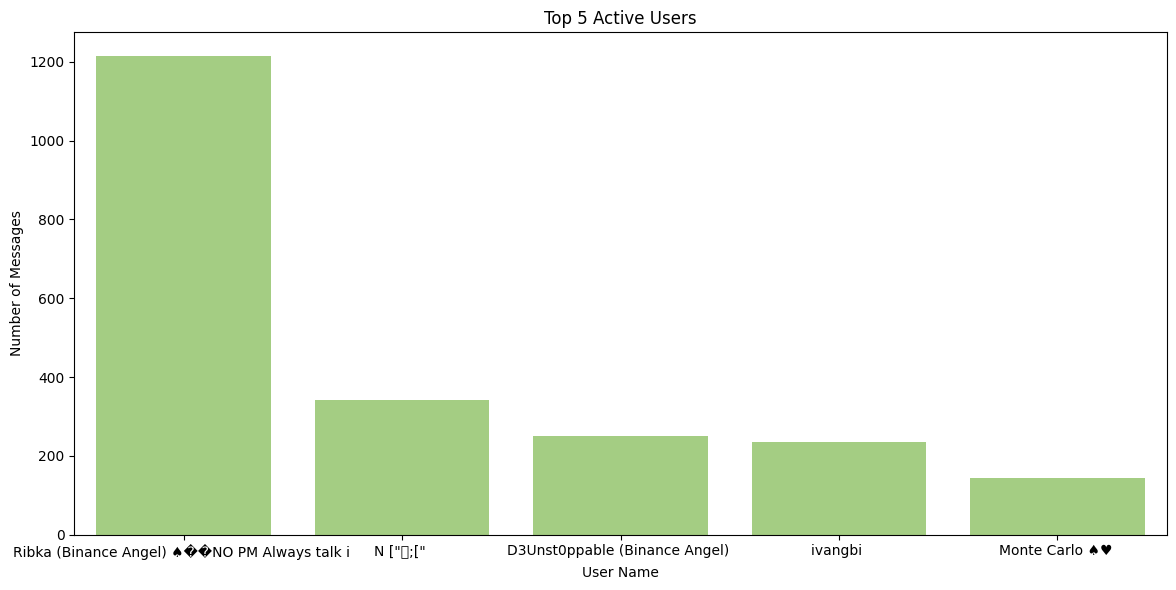

                                        full_name  message_count
0  Ribka (Binance Angel) ♠️��NO PM Always talk i            1214
1                                       N ["⁧;["             342
2                  D3Unst0ppable (Binance Angel)             251
3                                        ivangbi             235
4                               Monte Carlo ♠️♥️             144

Names of the top 5 most active chats:
Chat ID: 1146170349, Name: Binance English
Chat ID: 1030379032, Name: >>> telegram.Bot()
Chat ID: 1242127973, Name: LobsterDAO ��

Detailed information about top 5 users:
+---------------------------------+----------------------------------------------------+
| User ID                         | 611740329                                          |
+---------------------------------+----------------------------------------------------+
| Name                            | Ribka (Binance Angel) ♠️��NO PM Always talk i None |
+---------------------------------+---------

In [39]:
# Function to adjust chat IDs
def normalize_chat_id(chat_id):
    chat_id_str = str(chat_id)
    if chat_id_str.startswith('-100'):
        return int(chat_id_str[4:])
    return int(chat_id)

# Normalize chat IDs in human_messages_df
human_messages_df.loc[:, 'chat_id'] = human_messages_df['chat_id'].apply(normalize_chat_id)

# Normalize chat IDs in chat_info_df
chat_info_df.loc[:, 'id'] = chat_info_df['id'].apply(normalize_chat_id)

# Identify the top 5 users by message count
top_users = human_messages_df['from_user'].value_counts().head(5)
top_users_df = pd.DataFrame({'user_id': top_users.index, 'message_count': top_users.values})

# Merge with user_info_df to get user names
top_users_with_names = pd.merge(top_users_df, user_info_df[['id', 'first_name', 'last_name']], left_on='user_id', right_on='id', how='left')

# Create full name
top_users_with_names['full_name'] = top_users_with_names['first_name'] + " " + top_users_with_names['last_name'].fillna('')

# Sort by message count descending
top_users_with_names = top_users_with_names.sort_values('message_count', ascending=False)

# Plot top 5 active users with names
plt.figure(figsize=(12, 6))
sns.barplot(x='full_name', y='message_count', data=top_users_with_names)
plt.title('Top 5 Active Users')
plt.xlabel('User Name')
plt.ylabel('Number of Messages')
plt.tight_layout()
plt.show()

# Print the data for verification
print(top_users_with_names[['full_name', 'message_count']])

# Analyze user participation across different chats
user_chat_participation = human_messages_df[human_messages_df['from_user'].isin(top_users.index)]
user_chat_counts = user_chat_participation.groupby('from_user')['chat_id'].nunique().sort_values(ascending=False)

# Create activity across chats, used further in the analysis
user_chat_activity = user_chat_participation.groupby(['from_user', 'chat_id']).size().unstack(fill_value=0)
user_chat_activity = user_chat_activity.reindex(columns=user_chat_activity.sum().sort_values(ascending=False).index)

# Get chat names for the top 5 chats
top_5_chats = user_chat_activity.sum().sort_values(ascending=False).head(5).index
chat_names = chat_info_df[chat_info_df['id'].isin(top_5_chats)].set_index('id')['name']

print("\nNames of the top 5 most active chats:")
for chat_id in top_5_chats:
    print(f"Chat ID: {chat_id}, Name: {chat_names.get(chat_id, 'Unknown')}")

# Get user info for top 5 users
top_user_info = user_info_df[user_info_df['id'].isin(top_users.index)].set_index('id')

print("\nDetailed information about top 5 users:")

for user_id in top_users.index[:5]:
    user = top_user_info.loc[user_id]
    
    # User info table
    user_info = [
        ["User ID", user_id],
        ["Name", f"{user['first_name']} {user['last_name']}"],
        ["Username", user['username']],
        ["Total messages", top_users[user_id]],
        ["Number of chats participated in", user_chat_counts[user_id]]
    ]
    print(tabulate(user_info, tablefmt="grid"))
    
    # Top 3 chats table
    print("\nTop 3 most active chats:")
    top_3_chats = user_chat_activity.loc[user_id].sort_values(ascending=False).head(3)
    chat_info = [
        [chat_id, chat_names.get(chat_id, 'Unknown'), message_count]
        for chat_id, message_count in top_3_chats.items()
    ]
    print(tabulate(chat_info, headers=["Chat ID", "Chat Name", "Messages"], tablefmt="grid"))
    
    print("\n" + "="*50 + "\n")  # Separator between users


Top 5 users in each chat

/Users/ajda/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8295 (\N{RIGHT-TO-LEFT ISOLATE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


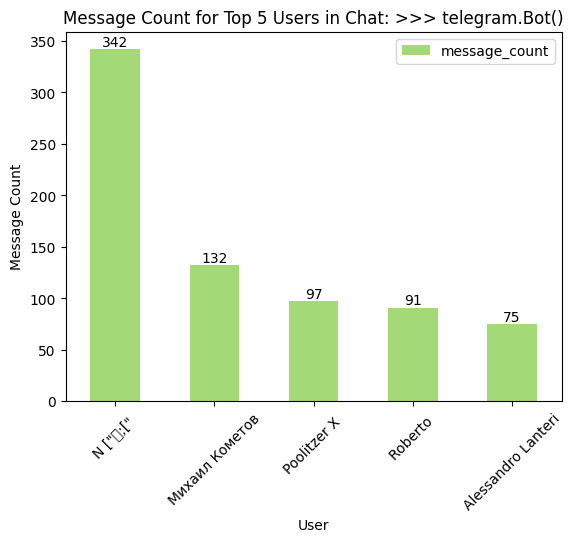

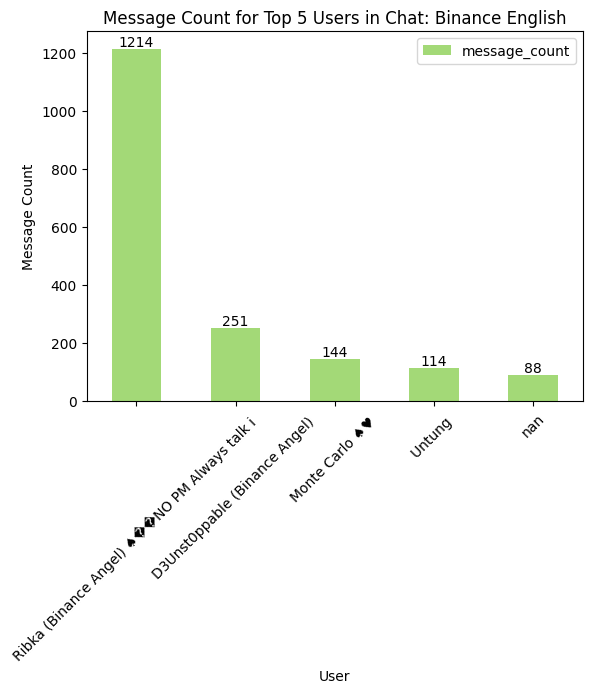

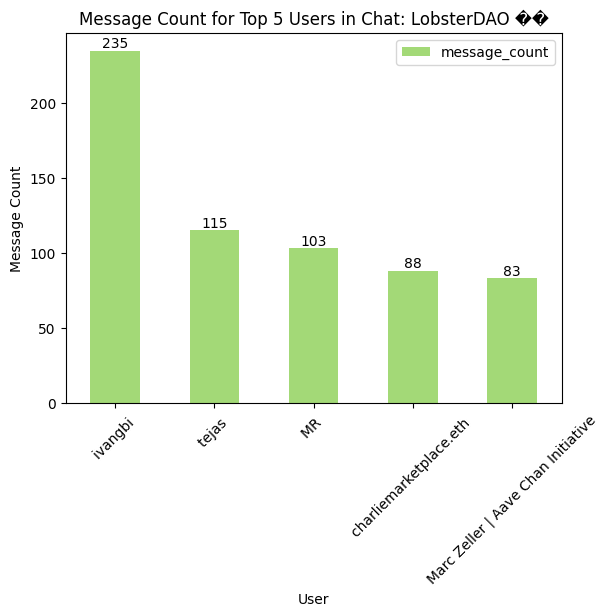

In [40]:
# Find the top users in each chat
top_users = human_messages_df.groupby(['chat_id', 'from_user'])['date'].count().reset_index(name='message_count')
top_users = top_users.sort_values(['chat_id', 'message_count'], ascending=[True, False])

# Merge with chat_info_df and user_info_df
top_users_with_names = pd.merge(top_users, chat_info_df[['id', 'name']], left_on='chat_id', right_on='id', how='left')
top_users_with_names = pd.merge(top_users_with_names, user_info_df[['id', 'first_name', 'last_name']], left_on='from_user', right_on='id', how='left')
top_users_with_names['full_name'] = top_users_with_names['first_name'] + " " + top_users_with_names['last_name'].fillna('')

# Print the top 5 users for each chat and create a histogram
for chat_id, chat_users in top_users_with_names.groupby('chat_id'):
    top_5_users = chat_users[['full_name', 'message_count']].head(5)
    # Create a histogram for the top 5 users in this chat
    ax = top_5_users.plot(x='full_name', y='message_count', kind='bar')
    plt.title(f"Message Count for Top 5 Users in Chat: {chat_users['name'].unique()[0]}")
    plt.xlabel("User")
    plt.ylabel("Message Count")
    plt.xticks(rotation=45)
    
    # Add numbers on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
    plt.show()
    print()


Word cloud for each chat

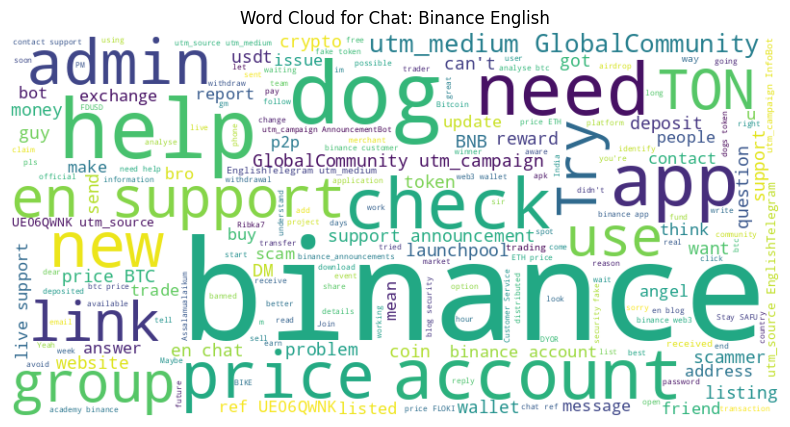

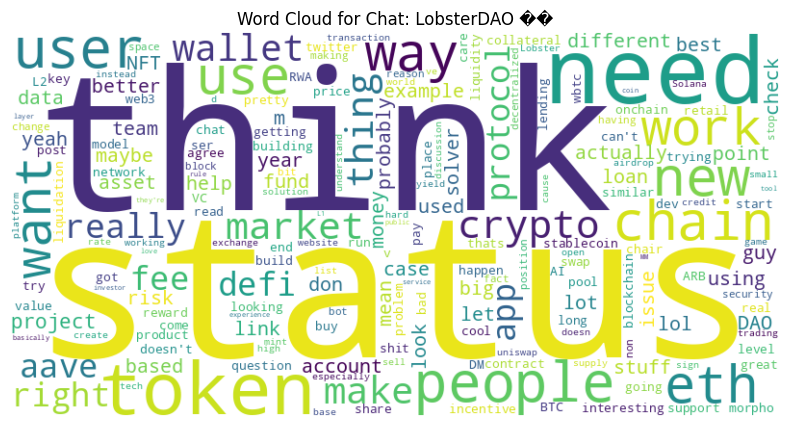

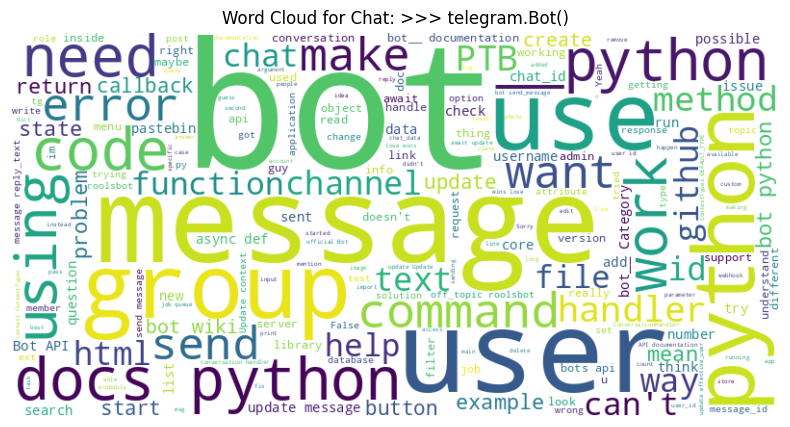

In [41]:
def create_word_cloud(text, stopwords, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def cloud_for_each_chat(df, chat_info):
    # Create stopwords
    stopwords = set(CountVectorizer(stop_words='english').get_stop_words())
    stopwords = stopwords.union(set(['http', 'https', 'www', 'com', 'org', 'net', 'telegram', 't', 'com','x','like','S','just','hello',
                                     'hi','hey','ok','good','morning','evening','night','day','time','today','tomorrow','yesterday',
                                     'dont',"don't", "i'm", 'yes', 'no', 'ok', 'okay', 'sure', 'thank', 'thanks', 'welcome', 'bye', 'goodbye',
                                     'did', 'does', 'doing', 'done', 'say', 'saying', 'said', 'ask', 'asking', 'asked', 'know', 'known',]))
    
    # Rename columns in chat_info
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)  # Ensure id is integer for merging
    
    # Merge DataFrames
    merged_df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')
    
    # Create word cloud for each unique chat
    for chat_id in merged_df['chat_id'].unique():
        chat_messages = merged_df[merged_df['chat_id'] == chat_id]
        chat_name = chat_messages['chat_name'].iloc[0]
        chat_text = ' '.join(chat_messages['text'].astype(str))
        
        create_word_cloud(chat_text, stopwords, f'Word Cloud for Chat: {chat_name}')

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function
cloud_for_each_chat(human_messages_df, chat_info)

Actvivity heatmap

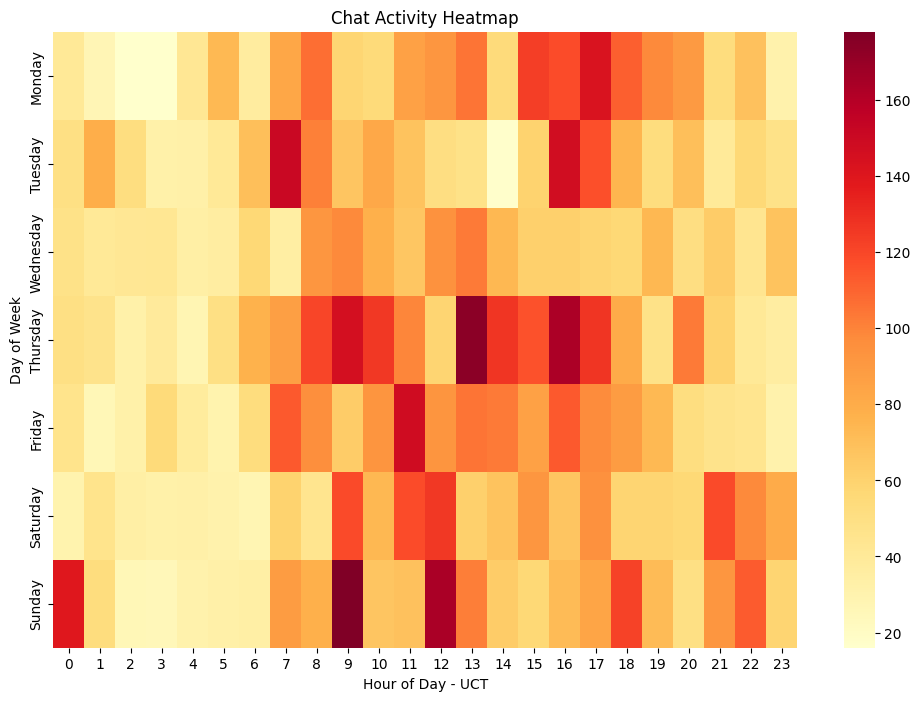

In [42]:
# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Create new columns for hour and day of week
human_messages_df['hour'] = human_messages_df['date'].dt.hour
human_messages_df['day_of_week'] = human_messages_df['date'].dt.day_name()

# Create the activity heatmap
activity_heatmap = human_messages_df.groupby(['day_of_week', 'hour']).size().unstack()

# Check if all days of the week are present in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
if set(activity_heatmap.index) == set(day_order):
    activity_heatmap = activity_heatmap.reindex(day_order)
else:
    print("Warning: Not all days of the week are present in the data.")

# Create the heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlOrRd')
plt.title('Chat Activity Heatmap')
plt.xlabel('Hour of Day - UCT')
plt.ylabel('Day of Week')
plt.show()

Moste active chats


Top 5 Most Active Chats:
                 name  message_count  unique_user_count  messages_per_user  \
0     Binance English           7025               1910           3.678010   
1       LobsterDAO ��           2740                458           5.982533   
2  >>> telegram.Bot()           2322                328           7.079268   

   activity_score  
0          5490.5  
1          2055.4  
2          1723.8  


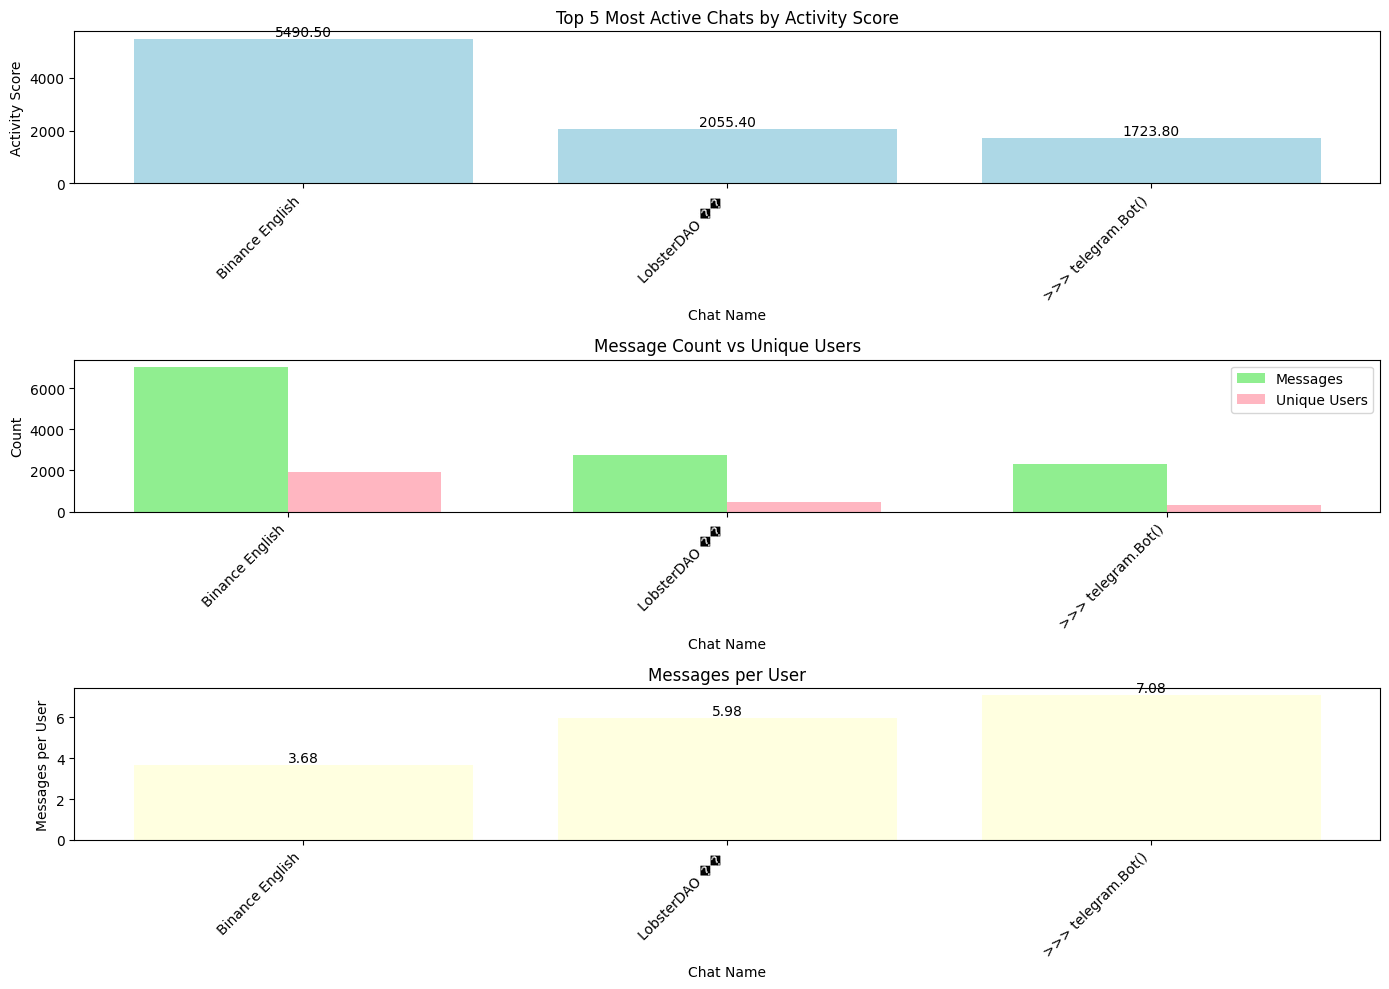

In [43]:
# Process chat IDs
human_messages_df['chat_id'] = human_messages_df['chat_id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x)).astype(int)

# Count messages per chat
chat_counts = human_messages_df['chat_id'].value_counts().reset_index()
chat_counts.columns = ['id', 'message_count']

# Count unique users per chat
unique_users_df = human_messages_df.groupby('chat_id')['from_user'].nunique().reset_index()
unique_users_df.columns = ['id', 'unique_user_count']

# Merge message counts and unique user counts
chat_stats = pd.merge(chat_counts, unique_users_df, on='id', how='left')

# Merge with chat names
chat_stats = pd.merge(chat_stats, chat_info_df[['id', 'name']], on='id', how='left')

# Calculate messages per user ratio
chat_stats['messages_per_user'] = chat_stats['message_count'] / chat_stats['unique_user_count']

# Calculate an activity score (you can adjust the weights as needed)
chat_stats['activity_score'] = (chat_stats['message_count'] * 0.7) + (chat_stats['unique_user_count'] * 0.3)

# Sort by activity score and get top 5
top_chats = chat_stats.sort_values('activity_score', ascending=False).head(5)

print("\nTop 5 Most Active Chats:")
print(top_chats[['name', 'message_count', 'unique_user_count', 'messages_per_user', 'activity_score']])

# Visualize the results
plt.figure(figsize=(14, 10))

# Plot for activity score
plt.subplot(3, 1, 1)
plt.bar(top_chats['name'], top_chats['activity_score'], color='lightblue')
plt.title('Top 5 Most Active Chats by Activity Score')
plt.xlabel('Chat Name')
plt.ylabel('Activity Score')
plt.xticks(rotation=45, ha='right')
for i, score in enumerate(top_chats['activity_score']):
    plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

# Plot for message count and unique users
plt.subplot(3, 1, 2)
width = 0.35
x = range(len(top_chats))
plt.bar(x, top_chats['message_count'], width, label='Messages', color='lightgreen')
plt.bar([i + width for i in x], top_chats['unique_user_count'], width, label='Unique Users', color='lightpink')
plt.title('Message Count vs Unique Users')
plt.xlabel('Chat Name')
plt.ylabel('Count')
plt.xticks([i + width/2 for i in x], top_chats['name'], rotation=45, ha='right')
plt.legend()

# Plot for messages per user
plt.subplot(3, 1, 3)
plt.bar(top_chats['name'], top_chats['messages_per_user'], color='lightyellow')
plt.title('Messages per User')
plt.xlabel('Chat Name')
plt.ylabel('Messages per User')
plt.xticks(rotation=45, ha='right')
for i, ratio in enumerate(top_chats['messages_per_user']):
    plt.text(i, ratio, f'{ratio:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Sentimental and emotional analysis of group texts

In [44]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to download NRC Emotion Lexicon
def download_nrc_lexicon():
    url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    response = requests.get(url)
    lines = response.text.split("\n")
    lexicon = {}
    for line in lines:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            word, emotion, value = parts
            if word not in lexicon:
                lexicon[word] = {}
            lexicon[word][emotion] = int(value)
    return lexicon

# Download the NRC Emotion Lexicon
nrc_lexicon = download_nrc_lexicon()

# Function to get emotions from text
def get_emotions(text):
    if pd.isna(text) or not isinstance(text, str):
        return Counter()
    words = nltk.word_tokenize(text.lower())
    emotions = Counter()
    for word in words:
        if word in nrc_lexicon:
            emotions.update({emotion: score for emotion, score in nrc_lexicon[word].items() if score > 0})
    return emotions

# Function to get sentiment
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

[nltk_data] Downloading package punkt to /Users/ajda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


sentiment analysis

Average Sentiment for Chat: Binance English: 0.07


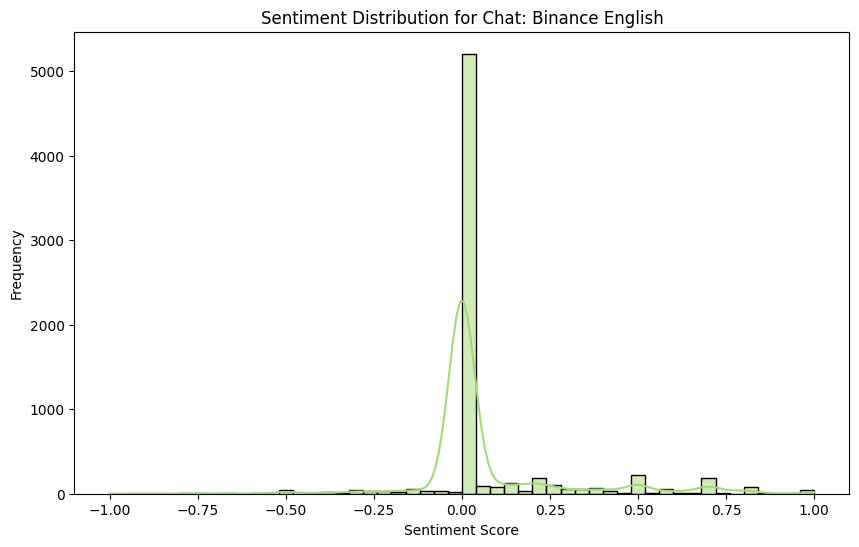

Average Sentiment for Chat: LobsterDAO ��: 0.09


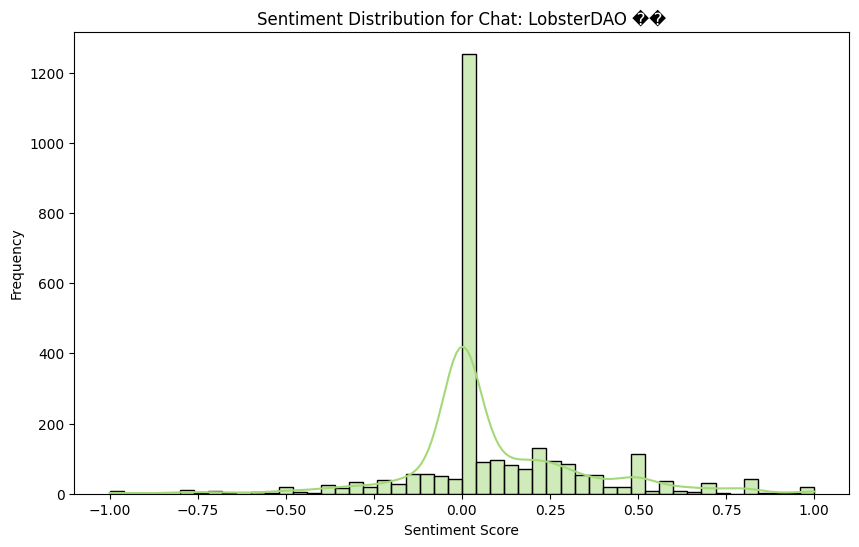

Average Sentiment for Chat: >>> telegram.Bot(): 0.03


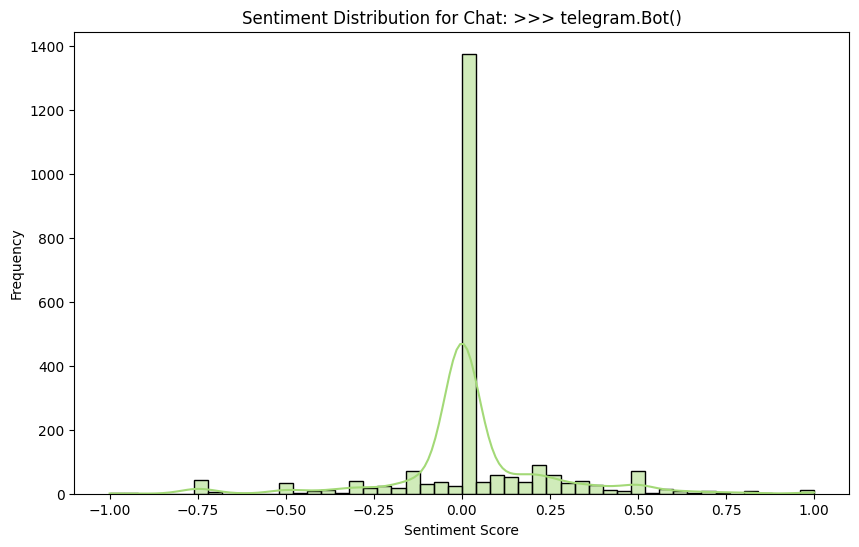

In [45]:
def analyze_sentiment(df, chat_info):
    # Rename columns in chat_info
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)  # Ensure id is integer for merging

    # Merge DataFrames
    merged_df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')

    # Apply sentiment analysis to all messages
    merged_df['sentiment'] = merged_df['text'].apply(get_sentiment)

    # Perform sentiment analysis for each unique chat
    for chat_id in merged_df['chat_id'].unique():
        chat_messages = merged_df[merged_df['chat_id'] == chat_id]
        chat_name = chat_messages['chat_name'].iloc[0]

        avg_sentiment = chat_messages['sentiment'].mean()
        print(f"Average Sentiment for Chat: {chat_name}: {avg_sentiment:.2f}")

        # Plot sentiment distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(chat_messages['sentiment'], bins=50, kde=True)
        plt.title(f'Sentiment Distribution for Chat: {chat_name}')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        plt.show()

    return merged_df

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function and get the updated DataFrame
human_messages_df = analyze_sentiment(human_messages_df, chat_info)



Emotion analysis

Top 5 Words for Each of the Top 5 Emotions in Chat: Binance English
Emotion: positive
Top 5 Words:
binance, ��, good, how, no
Emotion: trust
Top 5 Words:
binance, good, ��, account, how
Emotion: anticipation
Top 5 Words:
good, ��, binance, morning, time
Emotion: joy
Top 5 Words:
good, ��, binance, morning, money
Emotion: negative
Top 5 Words:
binance, ��, no, problem, please


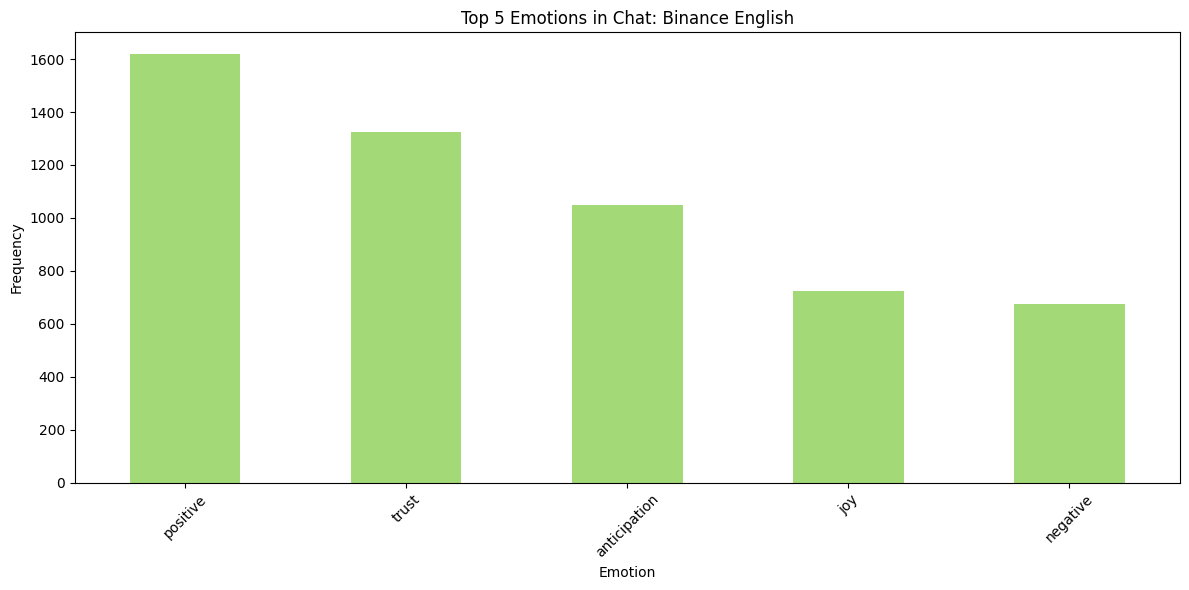

Top 5 Words for Each of the Top 5 Emotions in Chat: LobsterDAO ��
Emotion: positive
Top 5 Words:
there, more, what, all, good
Emotion: trust
Top 5 Words:
good, there, more, any, what
Emotion: negative
Top 5 Words:
all, more, there, what, people
Emotion: anticipation
Top 5 Words:
good, more, there, all, what
Emotion: joy
Top 5 Words:
good, more, there, any, money


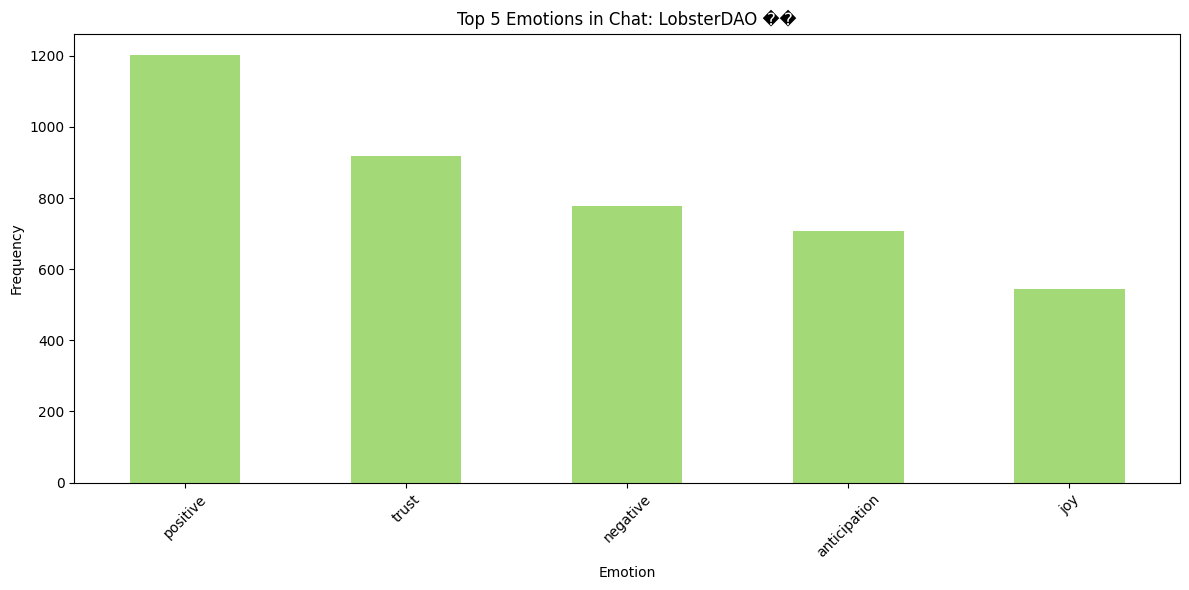

Top 5 Words for Each of the Top 5 Emotions in Chat: >>> telegram.Bot()
Emotion: positive
Top 5 Words:
bot, how, telegram, there, user
Emotion: trust
Top 5 Words:
bot, how, telegram, use, user
Emotion: negative
Top 5 Words:
bot, message, error, how, when
Emotion: anticipation
Top 5 Words:
bot, await, user, how, telegram
Emotion: sadness
Top 5 Words:
bot, error, problem, when, use


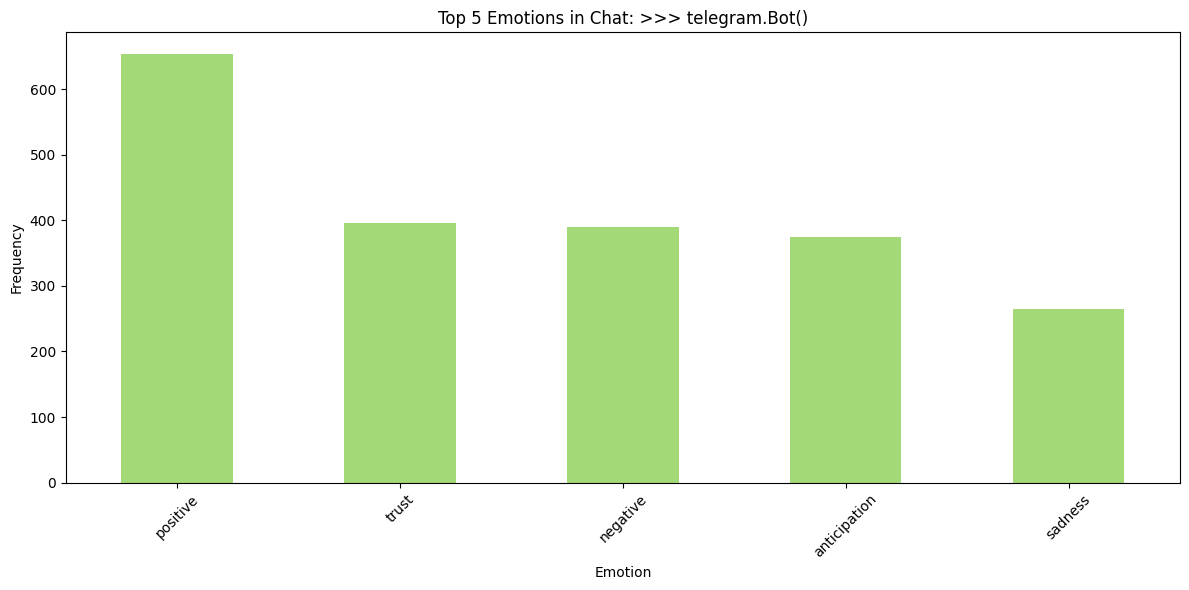

In [46]:
def analyze_emotions(df, chat_info, nrc_lexicon):
    # Rename columns in chat_info
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)  # Ensure id is integer for merging

    # Merge DataFrames
    merged_df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')

    all_chat_emotions = {}

    for chat_id in merged_df['chat_id'].unique():
        chat_messages = merged_df[merged_df['chat_id'] == chat_id]
        chat_name = chat_messages['chat_name_x'].iloc[0]

        # Emotion analysis
        chat_messages['emotions'] = chat_messages['text'].apply(get_emotions)
        emotion_counts = chat_messages['emotions'].explode().value_counts()

        print(f"Top 5 Words for Each of the Top 5 Emotions in Chat: {chat_name}")
        for emotion, count in emotion_counts.sort_values(ascending=False).head(5).items():
            print(f"Emotion: {emotion}")
            print("Top 5 Words:")
            
            # Get all words for this emotion in the current chat
            emotion_words = ' '.join(chat_messages[chat_messages['emotions'].apply(lambda x: emotion in x)]['text'].fillna('').astype(str))
            
            # Create a word frequency dictionary
            word_freq = Counter(emotion_words.lower().split())
            
            # Define a set of common words to exclude
            common_words = set(['the', 'to', 'a', 'is', 'and', 'of', 'in', 'it', 'for', 'on', 'that', 'with', 'as', 'at', 'by', 'from', 'an', 'be', 'this', 'was', 'are', 'or', 'have', 'has', 'had', 'not', 'but',
                                'about', 'so', 'if', 'you', 'your', 'my', 'me', 'i', 'we', 'our', 'us', 'they', 'them', 'he', 'she', 'his', 'her', 'him', 'their', 'will', 'can', 'could', 'would', 'should', 'do', 'did', 'does',
                                'done', 'doing', 'get', 'got', 'getting', 'gets', 'go', 'goes', 'going', 'went', 'gone', 'been', 'being', 'am', 'are', 'is', 'was', 'were', 'be', 'being', 'been', 'said', 'say', 'saying', 'says',
                                'tell', 'telling', 'tells', 'told', 'ask', 'asking', 'asks', 'asked', 'make', 'making', 'makes', 'made', 'come', 'coming', 'comes', 'came', 'give', 'giving', 'gives', 'gave', 'find', 'finding',
                                '-', 'just', 'like', 'im', 'dont', 'know', 'knows', 'knowing', 'known', 'knowingly', 'knowable', 'knowability', 'knowledgable', 'knowledgably', 'knowledgability', 'knowledgableness', 'knowledgably',
                                '='])
            
            # Filter out common words and get the top 5 meaningful words
            meaningful_words = [word for word, freq in word_freq.items() if word not in common_words]
            top_words = sorted([(word, word_freq[word]) for word in meaningful_words], key=lambda x: x[1], reverse=True)[:5]
            
            print(", ".join([word for word, freq in top_words]))

        # Plot emotion distribution
        plt.figure(figsize=(12, 6))
        emotion_counts.head(5).plot(kind='bar')
        plt.title(f'Top 5 Emotions in Chat: {chat_name}')
        plt.xlabel('Emotion')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Store the emotions for this chat
        all_chat_emotions[chat_id] = chat_messages['emotions']

    return all_chat_emotions

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function and store the returned emotions
all_emotions = analyze_emotions(human_messages_df, chat_info, nrc_lexicon)

Domination emotion by day for each group

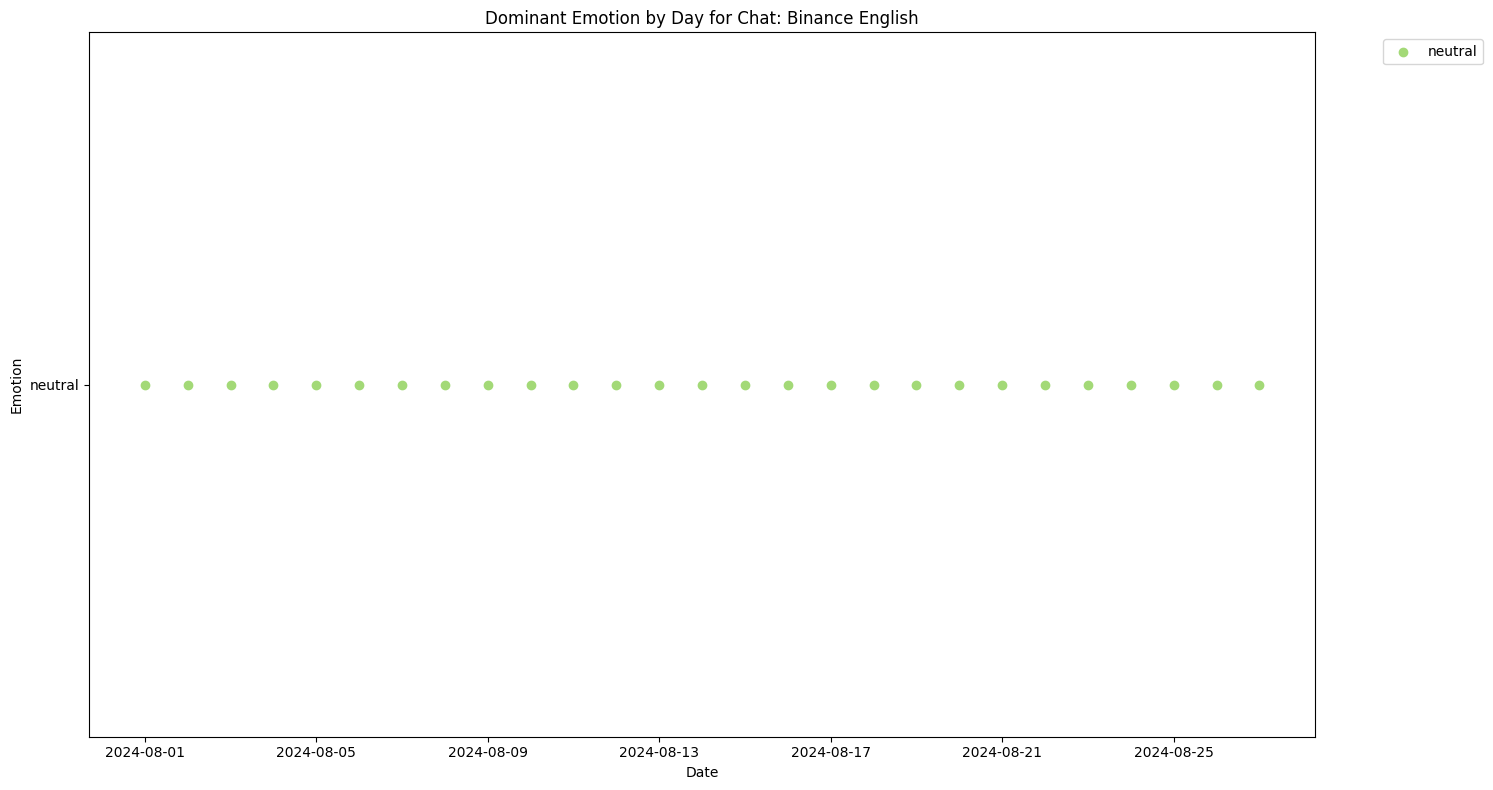

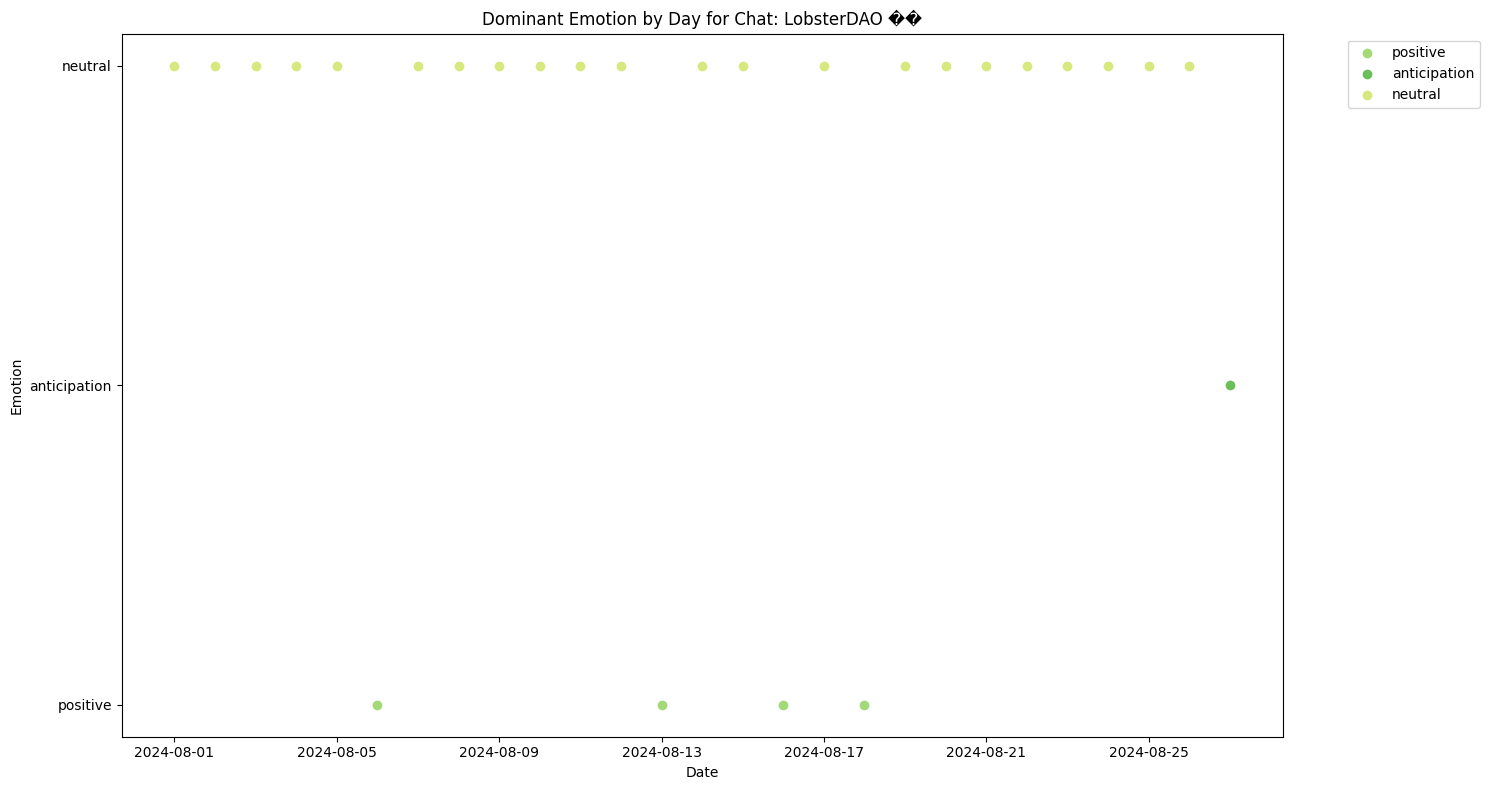

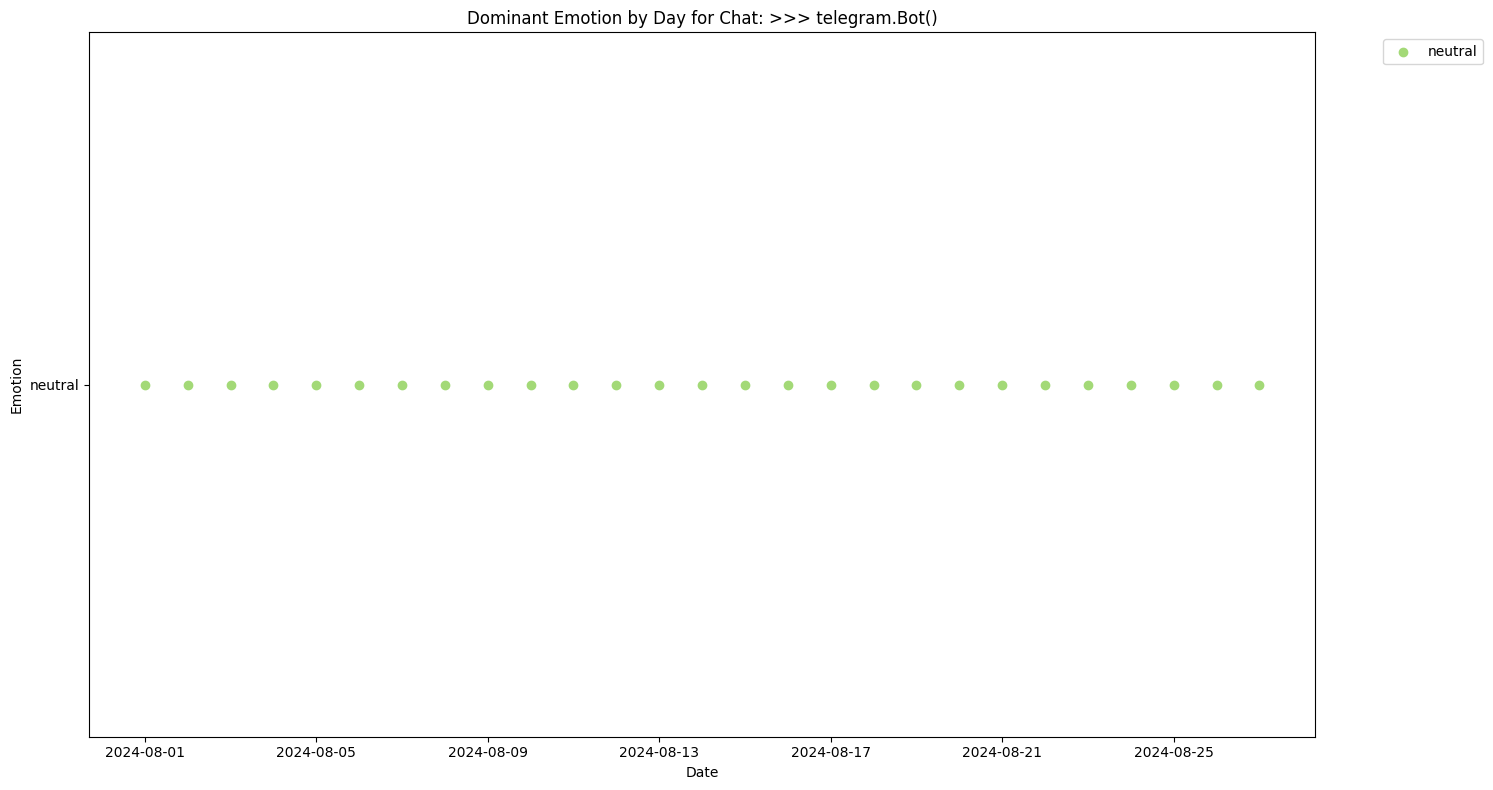

In [47]:
def analyze_emotions_over_time(df, chat_info):
    # Ensure date column is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Merge with chat_info to get chat names
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)
    df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')

    # Function to get the dominant emotion
    def get_dominant_emotion(emotions):
        return max(emotions, key=emotions.get) if emotions else 'neutral'

    # Apply get_emotions to the 'text' column if not already done
    if 'emotions' not in df.columns:
        df['emotions'] = df['text'].apply(get_emotions)

    df['dominant_emotion'] = df['emotions'].apply(get_dominant_emotion)
    # Analyze and plot for each chat
    for chat_id in df['chat_id'].unique():
        chat_df = df[df['chat_id'] == chat_id]
        chat_name = chat_df['chat_name_x'].iloc[0]

        chat_df = chat_df.set_index('date')

        # Resample by day and get the most common emotion
        daily_emotion = chat_df['dominant_emotion'].resample('D').agg(lambda x: x.value_counts().index[0] if len(x) > 0 else 'neutral')

        # Plot emotions over time
        plt.figure(figsize=(15, 8))
        for emotion in set(daily_emotion.values):
            emotion_days = daily_emotion[daily_emotion == emotion].index
            plt.scatter(emotion_days, [emotion] * len(emotion_days), label=emotion)

        plt.title(f'Dominant Emotion by Day for Chat: {chat_name}')
        plt.xlabel('Date')
        plt.ylabel('Emotion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function
analyze_emotions_over_time(human_messages_df, chat_info)

Top 5 users and their top emotions

In [48]:
# First, let's make sure we have the 'emotions' column
if 'emotions' not in human_messages_df.columns:
    human_messages_df['emotions'] = human_messages_df['text'].apply(get_emotions)

# Now proceed with the emotion analysis for top users
top_users = human_messages_df['from_user'].value_counts().head(5).index
for user in top_users:
    user_emotions = Counter()
    for emotions in human_messages_df[human_messages_df['from_user'] == user]['emotions']:
        user_emotions.update(emotions)
    
    print(f"\nTop 5 emotions for user {user}:")
    print(dict(user_emotions.most_common(5)))


Top 5 emotions for user 611740329:
{'positive': 342, 'trust': 273, 'anticipation': 230, 'negative': 109, 'joy': 98}

Top 5 emotions for user 140105449:
{'positive': 101, 'negative': 49, 'trust': 39, 'anticipation': 38, 'fear': 31}

Top 5 emotions for user 7226176635:
{'positive': 123, 'trust': 70, 'anticipation': 47, 'negative': 29, 'joy': 18}

Top 5 emotions for user 375542731:
{'positive': 173, 'trust': 114, 'negative': 84, 'anticipation': 69, 'fear': 55}

Top 5 emotions for user 5016247886:
{'positive': 35, 'anticipation': 28, 'trust': 23, 'joy': 20, 'surprise': 16}


Word cloud for each emotion

'dominant_emotion' column not found. Creating it now...


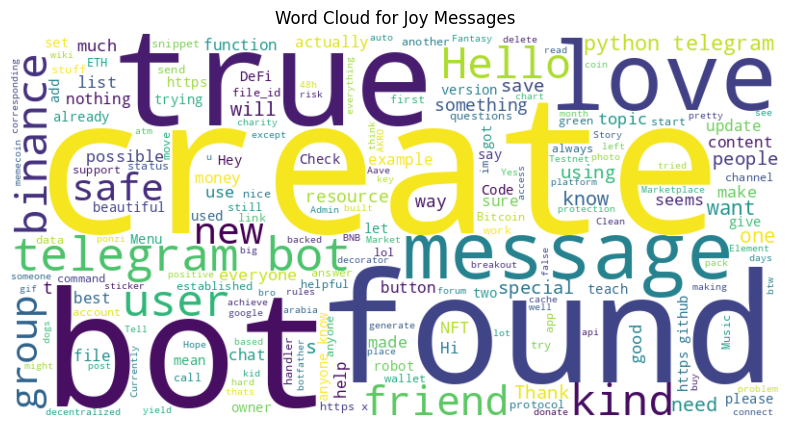

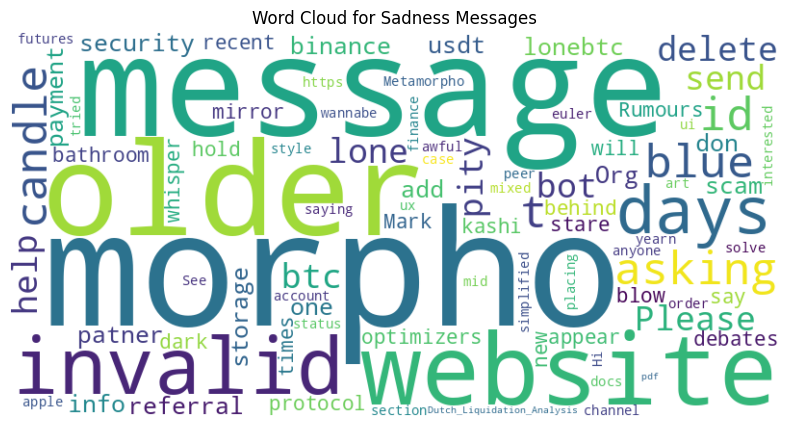

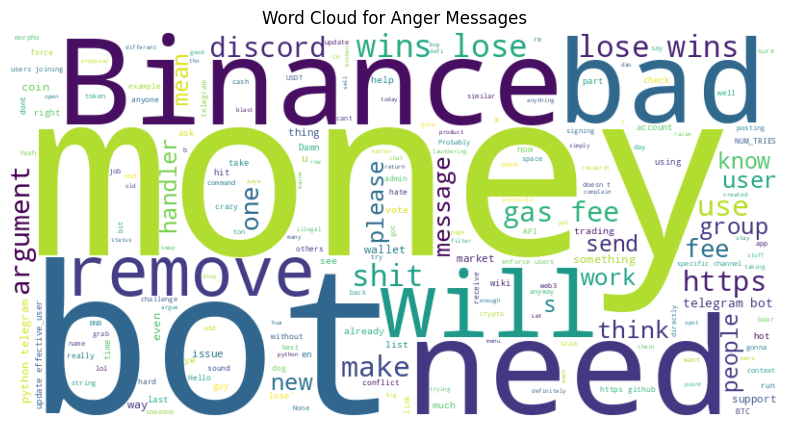

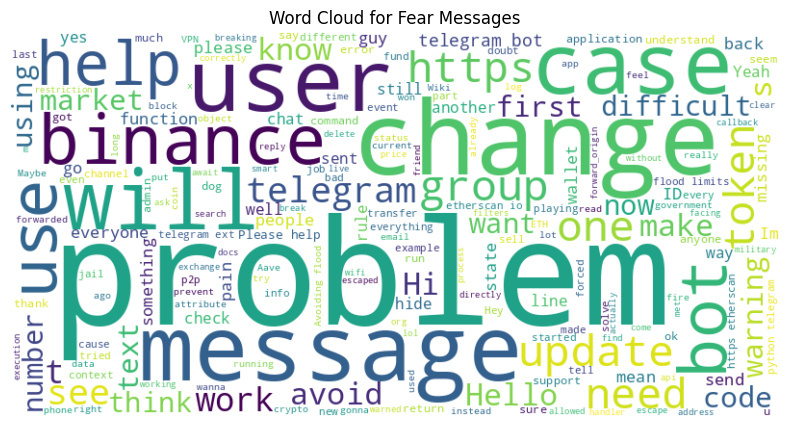

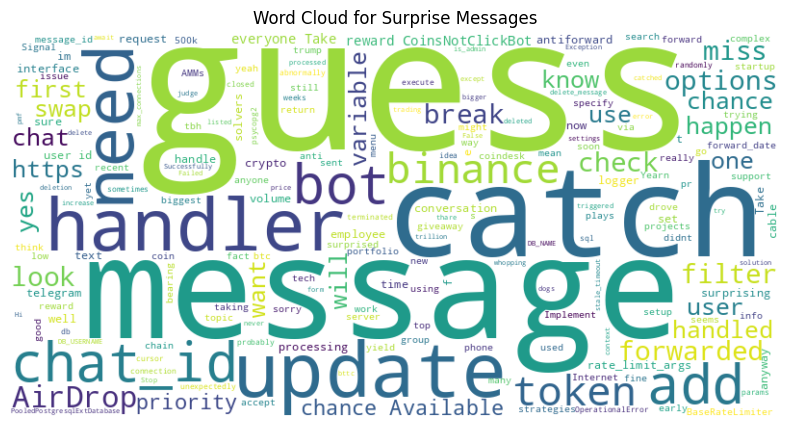

In [49]:
if 'dominant_emotion' not in human_messages_df.columns:
    print("'dominant_emotion' column not found. Creating it now...")
    
    # Function to get the dominant emotion
    def get_dominant_emotion(emotions):
        return max(emotions, key=emotions.get) if emotions else 'neutral'
    
    # Apply get_emotions to the 'text' column if not already done
    if 'emotions' not in human_messages_df.columns:
        human_messages_df['emotions'] = human_messages_df['text'].apply(get_emotions)
    
    human_messages_df['dominant_emotion'] = human_messages_df['emotions'].apply(get_dominant_emotion)

# Now proceed with the word cloud generation
for emotion in ['joy', 'sadness', 'anger', 'fear', 'surprise']:
    emotion_df = human_messages_df[human_messages_df['dominant_emotion'] == emotion]
    
    if emotion_df.empty:
        print(f"No messages found for emotion: {emotion}")
        continue
    
    emotion_words = ' '.join(emotion_df['text'].fillna('').astype(str))
    
    if emotion_words.strip():  # Check if there are any words for this emotion
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion.capitalize()} Messages')
        plt.show()
    else:
        print(f"No words found for emotion: {emotion}")

Correlation between sentiment and message

Correlation between sentiment and message length: 0.02


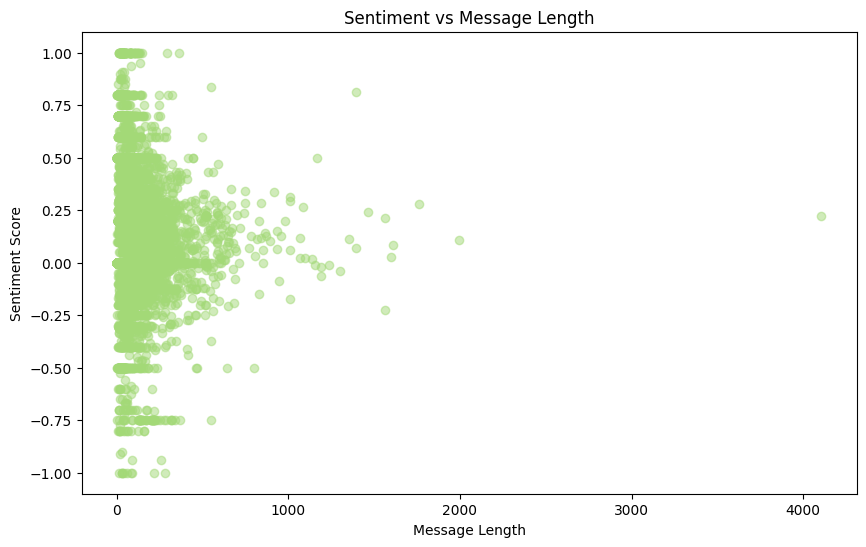

In [50]:
human_messages_df['message_length'] = human_messages_df['text'].fillna('').astype(str).str.len()
correlation = human_messages_df['sentiment'].corr(human_messages_df['message_length'])
print(f"Correlation between sentiment and message length: {correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(human_messages_df['message_length'], human_messages_df['sentiment'], alpha=0.5)
plt.title('Sentiment vs Message Length')
plt.xlabel('Message Length')
plt.ylabel('Sentiment Score')
plt.show()

## Media analysis

In [52]:
def analyze_reactions(df):
    # Count non-empty reactions
    non_empty_reactions = df['reactions'].dropna().str.strip().ne('').sum()
    
    # Get a sample of unique reaction strings
    unique_reactions = df['reactions'].dropna().str.strip().unique()
    sample_reactions = unique_reactions[:10] if len(unique_reactions) > 10 else unique_reactions
    
    return non_empty_reactions, sample_reactions

non_empty_reactions, sample_reactions = analyze_reactions(chat_history_df)

print(f"\nReaction Analysis:")
print("Sample of unique reaction strings:")
for reaction in sample_reactions:
    print(f"- {reaction}")


def extract_media_info(media_str):
    try:
        media_dict = ast.literal_eval(media_str)
        if isinstance(media_dict, dict) and 'webpage' in media_dict:
            webpage = media_dict['webpage']
            return {
                'type': webpage.get('type', 'Unknown'),
                'url': webpage.get('url', 'N/A'),
                'title': webpage.get('title', 'N/A'),
                'description': webpage.get('description', 'N/A'),
                'site_name': webpage.get('site_name', 'N/A'),
                'image_url': webpage.get('image', {}).get('url', 'N/A'),
                'video_url': webpage.get('video', {}).get('url', 'N/A')
            }
    except:
        type_match = re.search(r"type='([^']*)'", media_str)
        url_match = re.search(r"url='([^']*)'", media_str)
        return {
            'type': type_match.group(1) if type_match else 'Unknown',
            'url': url_match.group(1) if url_match else 'N/A',
            'title': 'N/A',
            'description': 'N/A',
            'site_name': 'N/A',
            'image_url': 'N/A',
            'video_url': 'N/A'
        }

def analyze_media(df):
    media_info = df['media'].dropna().apply(extract_media_info)
    
    media_types = media_info.apply(lambda x: x['type']).value_counts()
    media_df = pd.DataFrame({
        'Media Type': media_types.index,
        'Count': media_types.values
    })
    
    site_names = media_info.apply(lambda x: x['site_name']).value_counts().head(10)
    site_df = pd.DataFrame({
        'Site Name': site_names.index,
        'Count': site_names.values
    })
    
    has_image = media_info.apply(lambda x: x['image_url'] != 'N/A').sum()
    has_video = media_info.apply(lambda x: x['video_url'] != 'N/A').sum()
    
    return media_df, site_df, has_image, has_video, media_info

# Run the analyses
media_results, site_results, image_count, video_count, media_info = analyze_media(chat_history_df)

print("\nMedia Analysis:")
print(tabulate(media_results, headers='keys', tablefmt='psql'))

print("\nTop 10 Site Names:")
print(tabulate(site_results, headers='keys', tablefmt='psql'))

print(f"\nMedia with Images: {image_count}")
print(f"Media with Videos: {video_count}")

# Display a sample of media information (first 5)
print("\nSample of Media Information (first 5):")
for i, info in enumerate(media_info.head()):
    print(f"\nMedia {i+1}:")
    print(f"Type: {info['type']}")
    print(f"URL: {info['url']}")
    print(f"Title: {info['title']}")
    print(f"Description: {info['description'][:100]}..." if len(info['description']) > 100 else f"Description: {info['description']}")
    print(f"Site Name: {info['site_name']}")
    print(f"Has Image: {'Yes' if info['image_url'] != 'N/A' else 'No'}")
    print(f"Has Video: {'Yes' if info['video_url'] != 'N/A' else 'No'}")

# Create clickable links for media
def create_clickable_links(row):
    if pd.notna(row['media']):
        media_info = extract_media_info(row['media'])
        return f"[{media_info['type']} - {media_info['site_name']}]({media_info['url']})"
    return ""

chat_history_df['Clickable Media Links'] = chat_history_df.apply(create_clickable_links, axis=1)

# Display a sample of clickable links (first 5)
print("\nSample of Clickable Media Links (first 5):")
print(chat_history_df['Clickable Media Links'].head().to_string())



Reaction Analysis:
Sample of unique reaction strings:
- 
- ��:1
- ❤:2
- ��:2
- ��:1, ��:1
- ❤:1
- ❤:3
- ❤:2, ��:1
- ⚡:1, ��:1
- ❤:1, CustomEmoji:5274086291774906767:1

Media Analysis:
+----+-------------------------+---------+
|    | Media Type              |   Count |
|----+-------------------------+---------|
|  0 | photo                   |     563 |
|  1 | i                       |     310 |
|  2 | article                 |     152 |
|  3 | video/mp4               |     106 |
|  4 | image/webp              |      62 |
|  5 | application/x-tgsticker |      33 |
|  6 | telegram_channel        |      23 |
|  7 | telegram_message        |      20 |
|  8 | telegram_megagroup      |      15 |
|  9 | video/webm              |       9 |
| 10 | video                   |       7 |
| 11 | Unknown                 |       4 |
| 12 | document                |       3 |
| 13 | telegram_bot            |       1 |
| 14 | gif                     |       1 |
| 15 | telegram_stickerset     |       1 